# Configure Cluster Module Params

This notebook should be used as a test for ensuring correct cluster parameters before cluster processing.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for cluster module

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

In [2]:
from pathlib import Path

import yaml
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from lib.shared.file_utils import get_filename
from lib.cluster.cluster_eval import plot_cell_histogram, plot_cluster_sizes
from lib.cluster.phate_leiden_clustering import (
    phate_leiden_pipeline,
    plot_phate_leiden_clusters,
)
from lib.cluster.benchmark_clusters import (
    perform_resolution_thresholding,
    calculate_pair_recall,
    calculate_group_enrichment,
)
from lib.cluster.scrape_benchmarks import (
    generate_string_pair_benchmark,
    generate_corum_group_benchmark,
)
from lib.shared.configuration_utils import CONFIG_FILE_HEADER

In [3]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
    ROOT_FP = Path(config["all"]["root_fp"])

## <font color='red'>SET PARAMETERS</font>

### Cluster preprocessing

- `MIN_CELL_CUTOFFS`: Minimum cells for each gene to be used in clusetering analysis. More cells per gene increases confidence, but some dataset types (ex mitotic) may have an inherently low number of cells for a particular perturbation.

In [4]:
MIN_CELL_CUTOFFS = {"mitotic": 0, "interphase": 3, "all": 3}

PERTURBATION_NAME_COL = config["aggregate"]["perturbation_name_col"]

Cell count distribution for: mitotic
Number of genes below cutoff: 0
[]


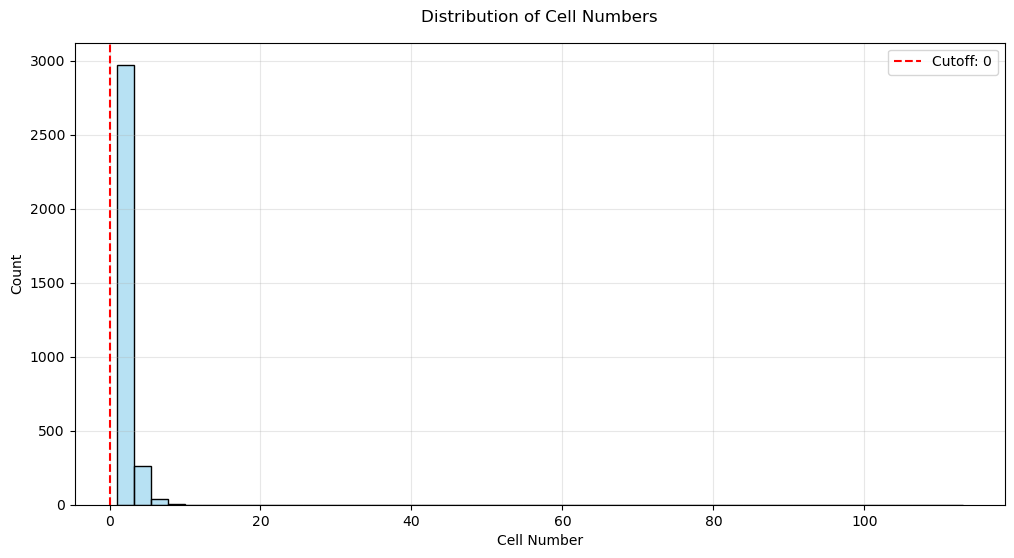

In [8]:
for cell_class, min_cell_cutoff in MIN_CELL_CUTOFFS.items():
    # load and clean relevant dataset
    aggregated_data_path = (
        Path("/lab/barcheese01/rkern/aggregate_overhaul/brieflow-analysis/analysis/analysis_root_OLD_DATA")
        / "aggregate"
        / "tsvs"
        / get_filename({"cell_class": cell_class}, "aggregated", "tsv")
    )
    aggregated_data = pd.read_csv(aggregated_data_path, sep="\t")

    # show cell count distribution
    print(f"Cell count distribution for: {cell_class}")
    plot_cell_histogram(aggregated_data, min_cell_cutoff, PERTURBATION_NAME_COL)
    plt.show()

    break  # TODO: REMOVE

## <font color='red'>SET PARAMETERS</font>

### Benchmark Generation

- `STRING_PAIR_BENCHMARK_FP`: Path to save and access STRING pair benchmark.
- `CORUM_GROUP_BENCHMARK_FP`: Path to save and access CORUM group benchmark.

**Note**: We use the following benchmark schemas:
- Pair Bechmark: `gene_name` column for gene matching with a cluster gene (or does not exist in cluster genes); `pair` column with a pair ID. Used to benchmark known pair relationships in generated cluster.
- Group Bechmark: `gene_name` column for gene matching with a cluster gene (or does not exist in cluster genes); `group` column with a group ID. Used to benchmark known group relationships in generated cluster, where a group represents genes involved in a pathway, protein complex, etc.

In [9]:
STRING_PAIR_BENCHMARK_FP = "config/benchmark_clusters/string_pair_benchmark.tsv"
CORUM_GROUP_BENCHMARK_FP = "config/benchmark_clusters/corum_group_benchmark.tsv"

In [10]:
# string_pair_benchmark = generate_string_pair_benchmark(aggregated_data, "gene_symbol_0")
# Path(STRING_PAIR_BENCHMARK_FP).parent.mkdir(parents=True, exist_ok=True)
# string_pair_benchmark.to_csv(STRING_PAIR_BENCHMARK_FP, sep="\t", index=False)
string_pair_benchmark = pd.read_csv(STRING_PAIR_BENCHMARK_FP, sep="\t")
display(string_pair_benchmark)

# corum_group_benchmark = generate_corum_group_benchmark()
# Path(CORUM_GROUP_BENCHMARK_FP).parent.mkdir(parents=True, exist_ok=True)
# corum_group_benchmark.to_csv(CORUM_GROUP_BENCHMARK_FP, sep="\t", index=False)
corum_group_benchmark = pd.read_csv(CORUM_GROUP_BENCHMARK_FP, sep="\t")
display(corum_group_benchmark)

,gene_name_variants,pair,gene_name
0,ARF5,1,ARF5
1,RAB11FIP3 ARFO1 KIAA0665,1,RAB11FIP3
2,M6PR MPR46 MPRD,2,M6PR
3,GGA3 KIAA0154,2,GGA3
4,M6PR MPR46 MPRD,3,M6PR
...,...,...,...
225791,LYL1 BHLHA18,117116,LYL1
225792,RFX7 RFXDC2,117117,RFX7
225793,RFXANK ANKRA1 RFXB,117117,RFXANK
225794,RFX7 RFXDC2,117118,RFX7


,gene_name,group
0,BCL6,0
1,HDAC4,0
2,BCL6,1
3,HDAC5,1
4,BCL6,2
...,...,...
18335,QRFPR,5363
18336,LRP4,5364
18337,SOST,5364
18338,HCRTR2,5365


## <font color='red'>SET PARAMETERS</font>

### Cluster Testing

- `TEST_CELL_CLASS`: Cell class to test clustering on. Usually `all` or cell class of interest.
- `LEIDEN_RESOLUTIONS`: Resolutions for testing Leiden clustering. Higher means more clusters.

In [11]:
TEST_CELL_CLASS = "all"

LEIDEN_RESOLUTIONS = [2, 5]
# Can do more clusters for higher plot resolution
# LEIDEN_RESOLUTIONS = [0.5, 1, 2, 5, 10, 20]

CONTROL_KEY = config["aggregate"]["control_key"]

In [13]:
# TODO: update to real paths
# aggregated_data_path = (
#     ROOT_FP
#     / "aggregate"
#     / "tsvs"
#     / get_filename({"cell_class": TEST_CELL_CLASS}, "aggregated", "tsv")
# )
# aggregated_data = pd.read_csv(aggregated_data_path, sep="\t")
aggregated_data_path = "/lab/barcheese01/rkern/aggregate_overhaul/brieflow-analysis/analysis/analysis_root_OLD_DATA/aggregate/parquets/CC-all__aggregated.parquet"
aggregated_data = pd.read_parquet(aggregated_data_path)

# create baseline data by shuffling columns independently
shuffled_aggregated_data = aggregated_data.copy()
feature_start_idx = shuffled_aggregated_data.columns.get_loc("PC_0")
feature_cols = shuffled_aggregated_data.columns[feature_start_idx:]
for col in feature_cols:
    shuffled_aggregated_data[col] = np.random.permutation(
        shuffled_aggregated_data[col].values
    )

# TODO: actually run this
# resolution_thresholding_df, resolution_thresholding_fig = (
#     perform_resolution_thresholding(
#         aggregated_data,
#         shuffled_aggregated_data,
#         LEIDEN_RESOLUTIONS,
#         string_pair_benchmark,
#         PERTURBATION_NAME_COL,
#         CONTROL_KEY,
#     )
# )

## <font color='red'>SET PARAMETERS</font>

### Cluster Generation

- `LEIDEN_RESOLUTION`: Final resolution for creating Leiden clusters.

In [14]:
LEIDEN_RESOLUTION = 5

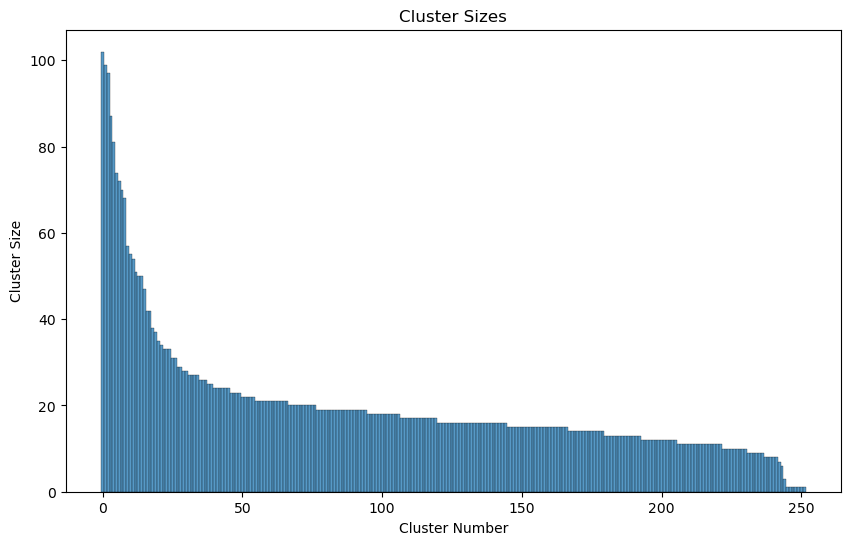

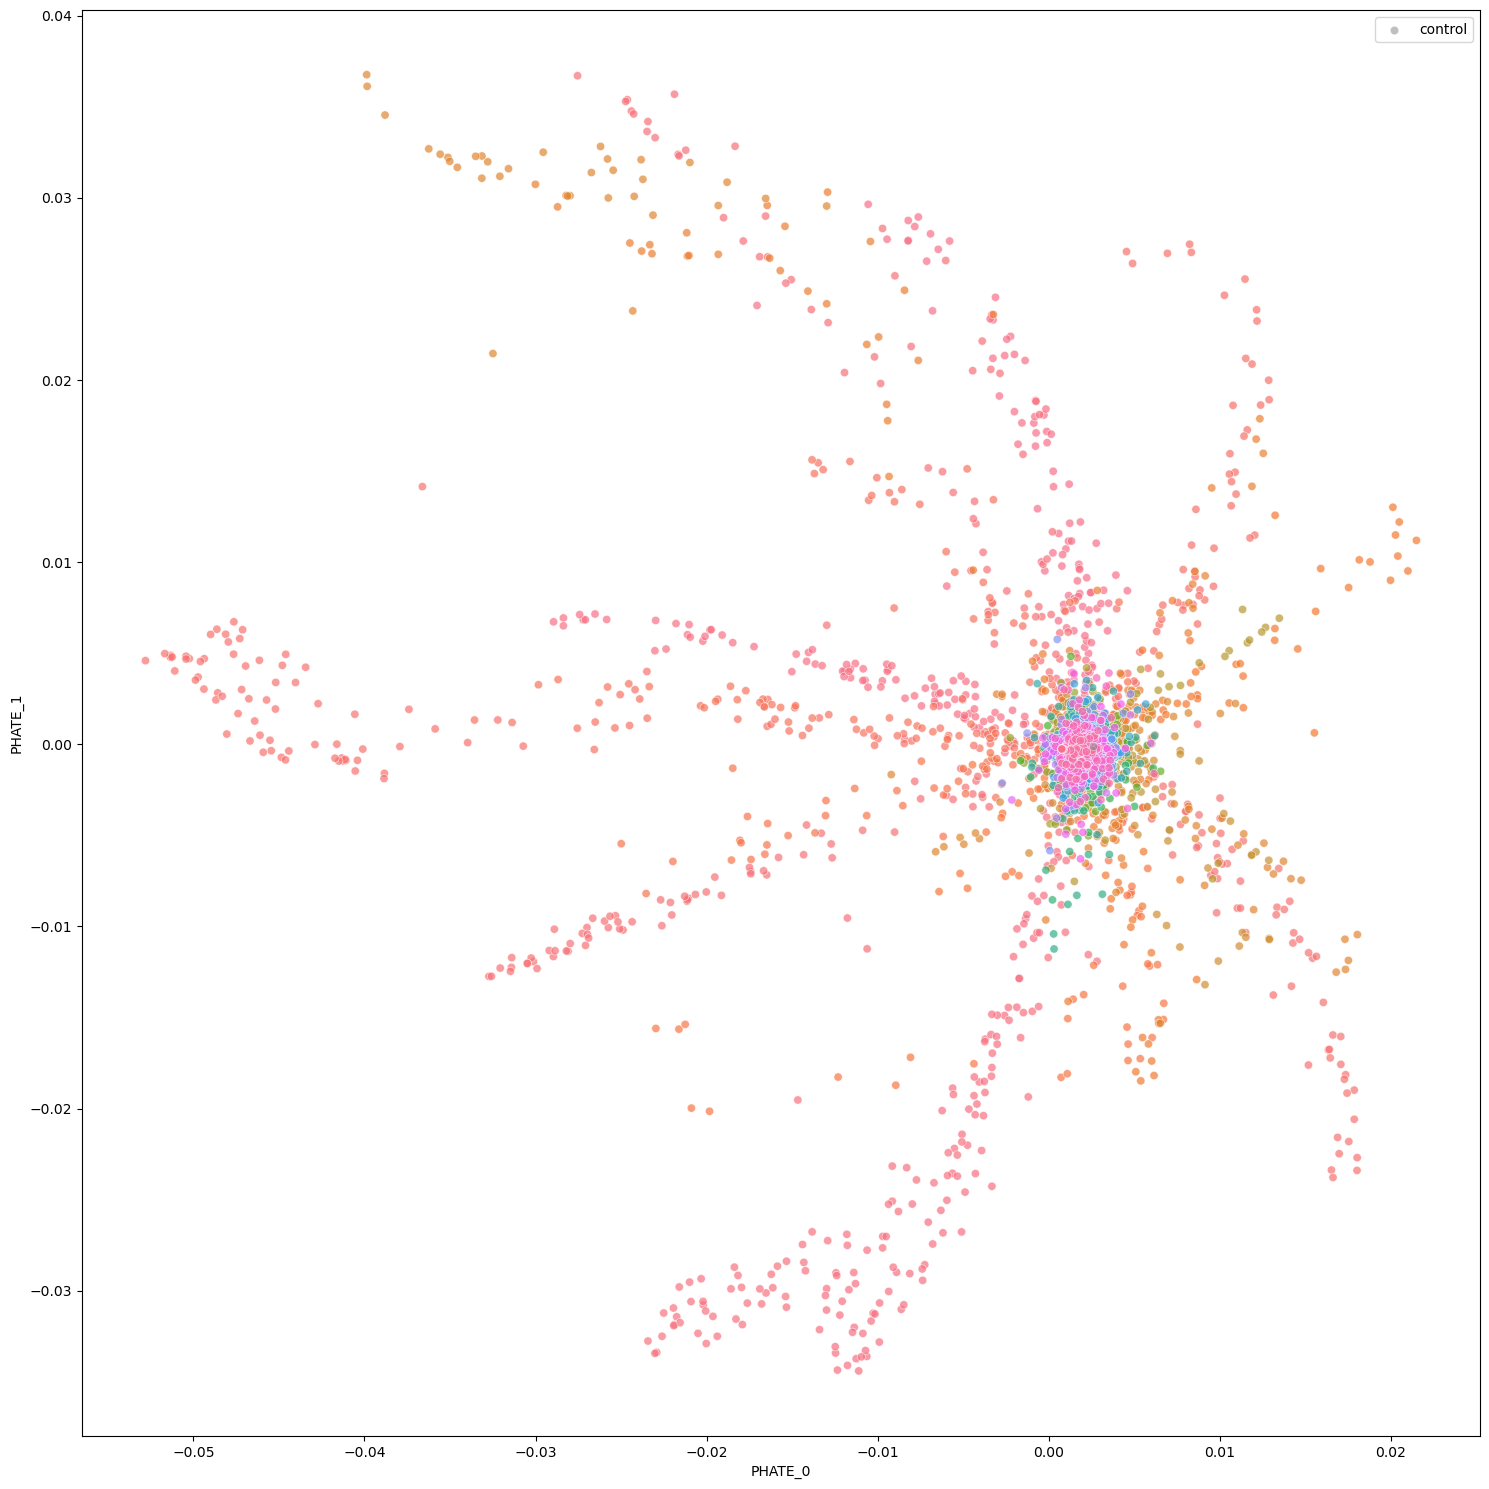

In [15]:
phate_leiden_clustering = phate_leiden_pipeline(
    aggregated_data,
    resolution=LEIDEN_RESOLUTION,
)
phate_leiden_clustering_shuffled = phate_leiden_pipeline(
    shuffled_aggregated_data,
    resolution=LEIDEN_RESOLUTION,
)

cluster_size_fig = plot_cluster_sizes(phate_leiden_clustering)

clusters_fig = plot_phate_leiden_clusters(
    phate_leiden_clustering, PERTURBATION_NAME_COL, CONTROL_KEY, figsize=(15, 15)
)

/tmp/ipykernel_1965513/2148041373.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels, rotation=45, ha="right")
/tmp/ipykernel_1965513/2148041373.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels, rotation=45, ha="right")


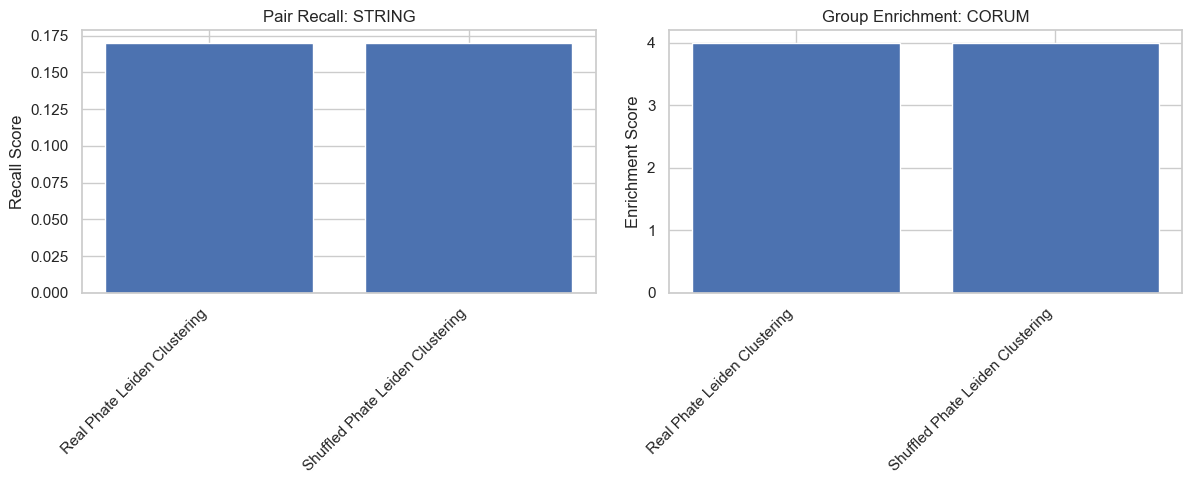

In [ ]:
cluster_datasets = {
    "Real Phate Leiden Clustering": phate_leiden_clustering,
    "Shuffled Phate Leiden Clustering": phate_leiden_clustering_shuffled,
}

pair_recall_benchmarks = {
    "STRING": string_pair_benchmark,
}

group_enrichment_benchmarks = {
    "CORUM": corum_group_benchmark,
}

import matplotlib.pyplot as plt

def plot_benchmark_results(cluster_datasets, pair_recall_benchmarks, group_enrichment_benchmarks):
    """Plot benchmark results for pair recall and group enrichment across clustering datasets.

    Args:
        cluster_datasets (dict): Mapping from dataset name to cluster DataFrame.
        pair_recall_benchmarks (dict): Mapping from benchmark name to pair benchmark DataFrame.
        group_enrichment_benchmarks (dict): Mapping from benchmark name to group benchmark DataFrame.

    Returns:
        matplotlib.figure.Figure: Figure with benchmark bar plots.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=False)
    
    # Plot pair recall
    for benchmark_name, benchmark_df in pair_recall_benchmarks.items():
        values = []
        labels = []
        for dataset_name, cluster_df in cluster_datasets.items():
            # score = calculate_pair_recall(
            #     benchmark_df,
            #     cluster_df,
            #     perturbation_col_name=PERTURBATION_NAME_COL,
            #     control_key=CONTROL_KEY,
            # )
            score = 0.17
            values.append(score)
            labels.append(f"{dataset_name}")
    ax1.bar(labels, values)
    ax1.set_title("Pair Recall")
    ax1.set_ylabel("Recall Score")
    ax1.set_xticklabels(labels, rotation=45, ha="right")

    # Plot group enrichment
    for benchmark_name, benchmark_df in group_enrichment_benchmarks.items():
        values = []
        labels = []
        for dataset_name, cluster_df in cluster_datasets.items():
            # score = calculate_group_enrichment(
            #     benchmark_df,
            #     cluster_df,
            #     perturbation_col_name=PERTURBATION_NAME_COL,
            #     control_key=CONTROL_KEY,
            # )
            score = 4
            values.append(score)
            labels.append(f"{dataset_name}")
    ax2.bar(labels, values)
    ax2.set_title("Group Enrichment")
    ax2.set_ylabel("Enrichment Score")
    ax2.set_xticklabels(labels, rotation=45, ha="right")

    fig.tight_layout()
    return fig

benchmark_results_fig = plot_benchmark_results(
    cluster_datasets,
    pair_recall_benchmarks,
    group_enrichment_benchmarks,
)

## Add cluster parameters to config file

In [ ]:
# Add cluster section
config["cluster"] = {
    "min_cell_cutoffs": MIN_CELL_CUTOFFS,
    "leiden_resolution": LEIDEN_RESOLUTION,
    "string_pair_benchmark": STRING_PAIR_BENCHMARK_FP,
    "corum_group_benchmark": CORUM_GROUP_BENCHMARK_FP,
}

# Write the updated configuration
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)